## Load Libraries and import modules 

In [6]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import os
import gc
from functools import reduce

# sklearn ml 
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [7]:
# check your current directory
savepath = os.getcwd() + "\\data\\"

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [8]:
from models_util import ml_helper as mlh 

# Load Data 

## Dataframe with Features

Since there are differences between R and python, I tried to combine the advantages of both. In R due to vectorization, it is faster to compute euclidean, manhattan and cosinde distances of matrices (with missing Values too).<br> 
In python correlation analysis is way faster than R. So...<br>
- To speed up python i tried to create custom functions where the distances are calculated via tensor algebra (it speeds things up)
- I will be using another matrix from a previous analysis in R to validate that the computations are correct. <br>

So for all the feature engineering practices where we have Protein A - Protein B pairs, I used the following naming sceme:<br>

```
features_dataframe:
Var1 - Var2 - [proteomics_type]_[feature_type]_[feature_analysis] - db

```
**Explanations**:<br>
The **Var1** and **Var2** are the protein or sims pairs (unique pairs), where Var1 > Var2 (as a way to remove duplicates and self combinations) <br>
The **proteomics type** could be **SCBC** or **ABMS** (subcellular or total cell MS proteomics)<br>
The **feature_type** could be the **raw** MS signals, or the **VAE** embeddings, or the **umap** coordinates, <br> 
The **feature_analysis** could be correlations, distances, angles, or any other feature. If there is time I will perform a **feature importance analysis** in more detail. <br>
The **db** are the classes of the classification based on ground truth databases of protein-protein interractions, 0 or 1. If we create the features with the purpose of training a classifier. 

**Example** of a columns of some features: 'SCBC_raw_pearson', 'ABMS_vae_umap', 'ABMS_vae_euclidean' <br>  
**The features dataframe** containing these columns could have protein pairs, proteoform dominant pairs (sims), or all the possible proteoform combinations outhere.<br>

**NOTE**<br>
For 34 million unique pairs, 14 features require around 32 minutes and do not crash the RAM, that csv file is around 20gb size  

In [9]:
# an old file written in R for validation of engineering the features correctly 
# feat = pd.read_csv(os.getcwd() + "\\data\\processed\\merged_features_v1.txt", delimiter="\t")

In [10]:
# feat["db"] = np.where(feat["db"]=="F",0,1)

## Data from Embeddings (VAE, umap) and Raw signals for gene or peptide centric Feature Eng.

Here I will construct some features for **protein-protein interractions** or for the **dominant (sim) proteoforms**, which have a corresponding **gene symbol**.<br>
- It is the same approach for different protein tables.
- The difference lies whether I will use the groudtruth data during feature engineering.
- For a subset of protein-protein pairs, which will be used to train the classifier, i will use the ground truth pairs.
- For the whole protein matrices, the purpose is to just engineer the features for all possible protein/sims pairs.
- This will have impact to the memory of the computer. <br>

For the **feature engineering** function we want Dataframes:<br>
- where **index** is either gene symbol or any other annotations used. Each row corresponds to a protein, proteoform, etc..
- where the **columns** are counts or MS signals (preferable normalized and harmonized) or VAE latent variables or UMAP coordinates. 
- index is important since we generate pairs and we need to name them or follow them somehow. 

In [11]:
#### SOME GLOBAL VARIABLES TO AID THE ANALYSIS ######
ANALYSIS_LEVEL = "protein" # "protein" OR "sims" for the the dominant proteoforms
USE_GROUND_TRUTH = True # if set to TRUE, it subsets the tables based on gene symbols that exist within the PPI databases for every function below 

# USE 3 IF GROUND TRUTH IS TRUE, OTHERWISE 10 ARE ENOUGH 
BLOCKS = 4 # calculate in a way that each block contains 1000 rows/proteins. So if you have 10000, use 10 blocks, 


In [12]:
if ANALYSIS_LEVEL == "protein":

    # for subcell
    raw_scbc = pd.read_csv(os.getcwd() + "\\data\\features_protein\\protein_quant_merged.txt", delimiter="\t", index_col=0)
    vae_scbc = pd.read_csv(os.getcwd() + "\\data\\features_protein\\proteinscbc_latent.csv", index_col=0)
    umap_scbc = pd.read_csv(os.getcwd() + "\\data\\features_protein\\protein_scbc_umap.csv", index_col=0)

    # for total cell 
    raw_abms = pd.read_csv(os.getcwd() + "\\data\\features_protein\\prot_abms_norm.txt", delimiter="\t")
    vae_abms = pd.read_csv(os.getcwd() + "\\data\\features_protein\\protein_abms_latent.csv", index_col=0)
    umap_abms = pd.read_csv(os.getcwd() + "\\data\\features_protein\\protein_abms_umap.csv", index_col=0)

    # for ground truth, the combined CORUM and Compleat datasets in gene symbol format 
    pairs_df = pd.read_csv(os.getcwd() + "\\data\\processed\\" + "merged_pairs.txt", delimiter="\t")

elif ANALYSIS_LEVEL == "sims":
    # for subcell 
    raw_scbc = pd.read_csv(os.getcwd() + "\\data\\features_sim\\scbc_quant_sims.csv", index_col=0)
    vae_scbc = pd.read_csv(os.getcwd() + "\\data\\features_sim\\simscbc_latent.csv", index_col=0)
    umap_scbc = pd.read_csv(os.getcwd() + "\\data\\features_sim\\sim_scbc_umap.csv", index_col=0)

    # for total cell 
    raw_abms = pd.read_csv(os.getcwd() + "\\data\\features_sim\\abms_quant_sims.csv", index_col=0)
    vae_abms = pd.read_csv(os.getcwd() + "\\data\\features_sim\\sim_abms_latent.csv", index_col=0)
    umap_abms = pd.read_csv(os.getcwd() + "\\data\\features_sim\\sim_abms_umap.csv", index_col=0)

    # for ground truth, the combined CORUM and Compleat datasets in gene symbol format 
    pairs_df = pd.read_csv(os.getcwd() + "\\data\\processed\\" + "merged_pairs.txt", delimiter="\t")

elif ANALYSIS_LEVEL == "proteoform":
    # overwrite global parameters for proetoform analysis
    BLOCK = 12 # many proteoforms in the dataframes 
    USE_GROUND_TRUTH = False # There is no ground truth for proteoform analysis 

    # for subcell 
    raw_scbc = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\SCBC2_proteoform_table 2.txt", index_col=0, delimiter="\t")
    vae_scbc = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\whole_proteoformscbc_latent.csv", index_col=0)
    umap_scbc = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\whole_proteoform_scbc_umap.csv", index_col=0)

    # filter out proteoform raw data 
    raw_scbc = raw_scbc.loc[raw_scbc.isna().sum(axis=1) < 0.3*raw_scbc.shape[1]]

    # for total cell 
    raw_abms = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\ABMS_proteoform_table.txt", decimal="\t", index_col=0)
    vae_abms = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\whole_proteoform_abms_latent.csv", index_col=0)
    umap_abms = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\whole_proteoform_abms_umap.csv", index_col=0)

else:
    raise ValueError("Choose either protein tables or dominant proteoform tables (sims) for analysis")

# check for duplicates in the indices and drop them (in case something survived)
for df in [raw_scbc, vae_scbc, umap_scbc, raw_abms, vae_abms, umap_abms]:
    print(f"Duplicates in {type(df)} before checking: {df.index.duplicated().sum()}")
    del df
    gc.collect()

# i found some in abms
raw_abms = raw_abms.loc[~raw_abms.index.duplicated(keep='first')]
vae_abms = vae_abms.loc[~vae_abms.index.duplicated(keep='first')]
umap_abms = umap_abms.loc[~umap_abms.index.duplicated(keep='first')]

Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0


In [22]:
# for total cell AML
raw_abms = pd.read_csv(os.getcwd() + "\\data\\aml_features\\AML_proteomics_TMT_NAs.txt", delimiter="\t")
vae_abms = pd.read_csv(os.getcwd() + "\\data\\aml_features\\protein_abms_latent.csv", index_col=0)
umap_abms = pd.read_csv(os.getcwd() + "\\data\\aml_features\\protein_abms_umap.csv", index_col=0)

raw_abms = raw_abms.loc[raw_abms.isna().sum(axis=1) < 0.5 * raw_abms.shape[1],:]

pairs_df = pd.read_csv(os.getcwd() + "\\data\\processed\\" + "corum_pairs.txt", delimiter="\t")

aml = pd.read_csv(os.getcwd() + "\\data\\aml_features\\aml_prot_features_dbcorum.csv", index_col=0)
# check for duplicates in the indices after clean up 
for df in [raw_abms, vae_abms, umap_abms]:
    print(f"Duplicates in {type(df)} before checking: {df.index.duplicated().sum()}")
    del df
    gc.collect()

Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0


In [ ]:
raw_abms.isna().sum(axis=1)

# ZYG11B  ZWIN

A1BG      9
A2M       0
AAAS      0
AACS      0
AAED1     0
         ..
ZWINT     0
ZXDC      0
ZYG11B    0
ZYX       0
ZZEF1     0
Length: 10103, dtype: int64

In [38]:
abms_features

,Var1,Var2,db,ABMS_raw_cor_pears,ABMS_raw_cor_spear,ABMS_raw_cos,ABMS_raw_euc,ABMS_raw_man,ABMS_raw_mean_dif,ABMS_raw_std_dif
0,ABCB1,AATF,0,0.167381,0.166091,0.834003,8.100488,68.749855,-0.025330,0.745280
1,ABCF2,AATF,0,0.033391,0.007512,0.927203,3.190350,27.274457,0.066171,0.286144
2,ABI1,AATF,0,0.017138,0.098244,0.989785,3.276532,27.532913,-0.036260,0.299442
3,ABI3,AATF,0,-0.134715,-0.112706,1.126824,6.909222,58.102940,0.014832,0.635873
4,ABL1,AATF,0,0.150176,0.225298,0.869192,2.586555,23.214239,-0.044829,0.233854
...,...,...,...,...,...,...,...,...,...,...
3730541,ZYG11B,ZWILCH,0,0.115238,0.134618,0.905228,3.553673,29.728264,-0.071942,0.319134
3730542,ZYX,ZWILCH,0,0.014240,0.099281,0.954261,4.889471,41.579022,0.006736,0.450062
3730543,ZYG11B,ZWINT,0,0.228416,0.254128,0.823831,5.809506,47.700318,-0.216205,0.489158
3730544,ZYX,ZWINT,0,-0.184358,-0.157042,1.106175,7.346293,63.835376,-0.137526,0.662150


In [46]:
# calculate manhatta for two vectors
from scipy.spatial.distance import euclidean, cosine, cityblock

 #calculate manhattan
print("Manhattan", cityblock(raw_abms.loc["ZYG11B",], raw_abms.loc["ZWINT",])) 
print("Euclidean", euclidean(raw_abms.loc["ZYG11B",], raw_abms.loc["ZWINT",]))
print("Cosine", cosine(raw_abms.loc["ZYG11B",], raw_abms.loc["ZWINT",]))

Manhattan 47.70031770569782
Euclidean 5.809505996891142
Cosine 0.8238310109168044


In [45]:
# calculate std difference between 2 veatcors mannualy 
diff = raw_abms.loc["ZYG11B",] - raw_abms.loc["ZWINT",]

np.mean(diff), np.std(diff), np.sum(np.abs(diff))

(0.2162047106837801, 0.48915797291595475, 47.70031770569782)

In [25]:
# check for duplicates in the indices after clean up 
for df in [raw_scbc, vae_scbc, umap_scbc, raw_abms, vae_abms, umap_abms]:
    print(f"Duplicates in {type(df)} before checking: {df.index.duplicated().sum()}")
    del df
    gc.collect()

Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0
Duplicates in <class 'pandas.core.frame.DataFrame'> before checking: 0


In [38]:
raw_abms.shape

(10103, 118)

# Feature Engineering for SubCell (SCBC features dataframe)

In [18]:
if USE_GROUND_TRUTH:
    ground = pairs_df
    merge_cols = ["Var1", "Var2", "db"]
else:
    ground = None
    merge_cols = ["Var1", "Var2"]

# calculate correlation coefficients for all the pairs in raw and VAE tables 
scbc_raw_corr = mlh.correlation_blockwise(raw_scbc,
                                          ground_truth= ground,
                                          data_name="SCBC_raw")

scbc_vae_corr = mlh.correlation_blockwise(vae_scbc,
                                          ground_truth= ground,
                                          data_name="SCBC_vae")


# merge the features with all the common values - no missing Values 
scbc_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [scbc_raw_corr, scbc_vae_corr])

# clean memory
del scbc_raw_corr, scbc_vae_corr
gc.collect()

# move db right after Var2
if USE_GROUND_TRUTH:
    scbc_features = scbc_features[["Var1", "Var2", "db"] + [col for col in scbc_features.columns if col not in ["Var1", "Var2", "db"]]]

# sanity check 
print(f"The feature dataframe has {scbc_features.shape[0]} rows and the following columns:\n {list(scbc_features.columns)}")
print(f"Missing Values in total in the features dataframe: {scbc_features.isna().sum().sum()}\n")

# calculate all the distance types in a for loop and merge them into a single dataframe in each loop 
for dist_type in ["manhattan", "std_difference", "euclidean"]:
    # for subcell
    scbc_raw_dist = mlh.compute_distances_blockwise(raw_scbc,
                                        ground_truth = ground,
                                        data_name = "SCBC_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)

    scbc_vae_dist = mlh.compute_distances_blockwise(vae_scbc,
                                        ground_truth = ground,
                                        data_name = "SCBC_vae",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)
    
    # merge in each iteration with the features dataframe
    scbc_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [scbc_features, scbc_raw_dist, scbc_vae_dist])

    # clean memory
    del scbc_raw_dist, scbc_vae_dist
    gc.collect()

    # sanity check 
    print(f"The feature dataframe has {scbc_features.shape[0]} rows and the following columns:\n {list(scbc_features.columns)}")
    print(f"Missing Values in total in the features dataframe: {scbc_features.isna().sum().sum()}\n")  


# compute cosine for RAW data and VAE embeddings 
scbc_raw_cos = mlh.compute_distances_blockwise(raw_scbc,
                                        ground_truth = ground,
                                        data_name = "SCBC_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = "cosine")
scbc_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [scbc_features, scbc_raw_cos])
del scbc_raw_cos
gc.collect()

scbc_vae_cos = mlh.compute_distances_blockwise(vae_scbc,
                                        ground_truth = ground,
                                        data_name = "SCBC_vae",
                                        n_chunks = BLOCKS,
                                        return_dist = "cosine")
scbc_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [scbc_features, scbc_vae_cos])
del scbc_vae_cos
gc.collect()


# finally lets add the UMAP euclidean and manhattan distances to the features dataframe
for dist_type in ["manhattan", "euclidean", "cosine"]:
    
    scbc_umap_dist = mlh.compute_distances_blockwise(umap_scbc,
                                        ground_truth = ground,
                                        data_name = "SCBC_umap",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)

    
    # merge in each iteration with the features dataframe
    scbc_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner"), [scbc_features, scbc_umap_dist])

    # clean memory
    del scbc_umap_dist
    gc.collect()

    # sanity check 
    print(f"The feature dataframe has {scbc_features.shape[0]} rows and the following columns:\n {list(scbc_features.columns)}")
    print(f"Missing Values in total in the features dataframe: {scbc_features.isna().sum().sum()}\n")  

# for consistancy separate and order columns 
excluded_cols = [col for col in scbc_features.columns if col in merge_cols]
other_cols = sorted([col for col in scbc_features.columns if col not in merge_cols])
final_col_order = excluded_cols + other_cols

# Reorder the DataFrame
scbc_features = scbc_features[final_col_order]
del excluded_cols, other_cols, final_col_order 


Analysis is starting for SCBC_raw to get pearson and spearman coefficients
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total, 3885 proteins were found in the database
Adding ground truth information to protein-protein distance metrics
Posιtive Class: 13008 pairs, Negative class: 3671247 pairs
The number of pairs generated is 3684255
Analysis is completed

Analysis is starting for SCBC_vae to get pearson and spearman coefficients
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total, 3885 proteins were found in the database
Adding ground truth information to protein-protein distance metrics
Posιtive Class: 13008 pairs, Negative class: 3671247 pairs


In [ ]:
# scbc_raw_corr = mlh.correlation_blockwise(raw_scbc,
#                                           ground_truth= ground,
#                                           data_name="SCBC_raw")

In [9]:
# scbc_features.shape

In [20]:
scbc_features.columns

Index(['Var1', 'Var2', 'db', 'SCBC_raw_cor_pears', 'SCBC_raw_cor_spear',
       'SCBC_raw_cos', 'SCBC_raw_euc', 'SCBC_raw_man', 'SCBC_raw_std_dif',
       'SCBC_umap_cos', 'SCBC_umap_euc', 'SCBC_umap_man', 'SCBC_vae_cor_pears',
       'SCBC_vae_cor_spear', 'SCBC_vae_cos', 'SCBC_vae_euc', 'SCBC_vae_man',
       'SCBC_vae_std_dif'],
      dtype='object')

In [21]:
if ANALYSIS_LEVEL == "protein":

    if USE_GROUND_TRUTH:
        scbc_features.to_csv(savepath + "features_protein\\scbc_protein_features_db.csv", header=True)
    else:
        scbc_features.to_csv(savepath + "features_protein\\scbc_protein_features_full.csv", header=True)

elif ANALYSIS_LEVEL == "sims":
    
    if USE_GROUND_TRUTH:
        scbc_features.to_csv(savepath + "features_sim\\scbc_sim_features_db2.csv", header=True)
    else:
        scbc_features.to_csv(savepath + "features_sim\\scbc_sim_features_full.csv", header=True)

elif ANALYSIS_LEVEL == "proteoform":
    scbc_features.to_csv(savepath + "features_proteoforms\\scbc_proteoform_features_full.csv", header=True)
    
else:
    raise RuntimeError("An ANALYSIS_LEVEL has not been specified")

# Feature Engineering for TotalCell (ABMS features dataframe)

In [84]:
vae_abms.shape, raw_abms.shape, umap_abms.shape

((10103, 30), (10103, 118), (10103, 3))

In [ ]:
if USE_GROUND_TRUTH:
    ground = pairs_df
    merge_cols = ["Var1", "Var2", "db"]
else:
    ground = None
    merge_cols = ["Var1", "Var2"]

# calculate correlation coefficients for all the pairs in raw and VAE tables 
abms_raw_corr = mlh.correlation_blockwise(raw_abms,
                                          ground_truth= ground,
                                          data_name="ABMS_raw")

abms_vae_corr = mlh.correlation_blockwise(vae_abms,
                                          ground_truth= ground,
                                          data_name="ABMS_vae")


# merge the features with all the common values - no missing Values 
abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_raw_corr, abms_vae_corr])

# clean memory
del abms_raw_corr, abms_vae_corr
gc.collect()

# move db right after Var2
if USE_GROUND_TRUTH:
    abms_features = abms_features[["Var1", "Var2", "db"] + [col for col in abms_features.columns if col not in ["Var1", "Var2", "db"]]]

# sanity check 
print(f"The feature dataframe has {abms_features.shape[0]} rows and the following columns:\n {list(abms_features.columns)}")
print(f"Missing Values in total in the features dataframe: {abms_features.isna().sum().sum()}\n")

# calculate all the distance types in a for loop and merge them into a single dataframe in each loop 
for dist_type in ["manhattan", "std_difference", "euclidean"]:
    # for subcell
    abms_raw_dist = mlh.compute_distances_blockwise(raw_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)

    abms_vae_dist = mlh.compute_distances_blockwise(vae_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_vae",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)
    
    # merge in each iteration with the features dataframe
    abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_features, abms_raw_dist, abms_vae_dist])

    # clean memory
    del abms_raw_dist, abms_vae_dist
    gc.collect()

    # sanity check 
    print(f"The feature dataframe has {abms_features.shape[0]} rows and the following columns:\n {list(abms_features.columns)}")
    print(f"Missing Values in total in the features dataframe: {abms_features.isna().sum().sum()}\n")

abms_vae_cos = mlh.compute_distances_blockwise(vae_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_vae",
                                        n_chunks = BLOCKS,
                                        return_dist = "cosine")

abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_features, abms_vae_cos])
del abms_vae_cos
gc.collect()

abms_raw_cos = mlh.compute_distances_blockwise(raw_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = "cosine")

abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_features, abms_raw_cos])
del abms_raw_cos
gc.collect()

# finally lets add the UMAP euclidean and manhattan distances to the features dataframe
for dist_type in ["manhattan", "euclidean", "cosine"]:
    
    abms_umap_dist = mlh.compute_distances_blockwise(umap_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_umap",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)

    
    # merge in each iteration with the features dataframe
    abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner"), [abms_features, abms_umap_dist])

    # clean memory
    del abms_umap_dist
    gc.collect()

    # sanity check 
    print(f"The feature dataframe has {abms_features.shape[0]} rows and the following columns:\n {list(abms_features.columns)}")
    print(f"Missing Values in total in the features dataframe: {abms_features.isna().sum().sum()}\n")  

# for consistancy separate and order columns 
excluded_cols = [col for col in abms_features.columns if col in merge_cols]
other_cols = sorted([col for col in abms_features.columns if col not in merge_cols])
final_col_order = excluded_cols + other_cols

# Reorder the DataFrame
abms_features = abms_features[final_col_order]
del excluded_cols, other_cols, final_col_order 

Analysis is starting for ABMS_raw to get pearson and spearman coefficients
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total, 3410 proteins were found in the database
Adding ground truth information to protein-protein distance metrics
Posιtive Class: 12936 pairs, Negative class: 3717610 pairs
The number of pairs generated is 3730546
Analysis is completed

Analysis is starting for ABMS_vae to get pearson and spearman coefficients
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total, 3410 proteins were found in the database
Adding ground truth information to protein-protein distance metrics
Posιtive Class: 12936 pairs, Negative class: 3717610 pairs


In [23]:
if USE_GROUND_TRUTH:
    ground = pairs_df
    merge_cols = ["Var1", "Var2", "db"]
else:
    ground = None
    merge_cols = ["Var1", "Var2"]

# calculate correlation coefficients for all the pairs in raw and VAE tables 
abms_raw_corr = mlh.correlation_blockwise(raw_abms,
                                          ground_truth= ground,
                                          data_name="ABMS_raw")


# merge the features with all the common values - no missing Values 
abms_features = abms_raw_corr

# clean memory
del abms_raw_corr
gc.collect()

# move db right after Var2
if USE_GROUND_TRUTH:
    abms_features = abms_features[["Var1", "Var2", "db"] + [col for col in abms_features.columns if col not in ["Var1", "Var2", "db"]]]

# sanity check 
print(f"The feature dataframe has {abms_features.shape[0]} rows and the following columns:\n {list(abms_features.columns)}")
print(f"Missing Values in total in the features dataframe: {abms_features.isna().sum().sum()}\n")

# calculate all the distance types in a for loop and merge them into a single dataframe in each loop 
for dist_type in ["manhattan", "std_difference", "euclidean", "mean_difference"]:
    # for subcell
    abms_raw_dist = mlh.compute_distances_blockwise(raw_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = dist_type)

    
    # merge in each iteration with the features dataframe
    abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_features, abms_raw_dist])

    # clean memory
    del abms_raw_dist
    gc.collect()

    # sanity check 
    print(f"The feature dataframe has {abms_features.shape[0]} rows and the following columns:\n {list(abms_features.columns)}")
    print(f"Missing Values in total in the features dataframe: {abms_features.isna().sum().sum()}\n")


abms_raw_cos = mlh.compute_distances_blockwise(raw_abms,
                                        ground_truth = ground,
                                        data_name = "ABMS_raw",
                                        n_chunks = BLOCKS,
                                        return_dist = "cosine")

abms_features = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how = "inner", validate="one_to_one"), [abms_features, abms_raw_cos])
del abms_raw_cos
gc.collect()

# for consistancy separate and order columns 
excluded_cols = [col for col in abms_features.columns if col in merge_cols]
other_cols = sorted([col for col in abms_features.columns if col not in merge_cols])
final_col_order = excluded_cols + other_cols

# Reorder the DataFrame
abms_features = abms_features[final_col_order]
del excluded_cols, other_cols, final_col_order 

Analysis is starting for ABMS_raw to get pearson and spearman coefficients
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total, 3410 proteins were found in the database
Adding ground truth information to protein-protein distance metrics
Posιtive Class: 12936 pairs, Negative class: 3717610 pairs
The number of pairs generated is 3730546
Analysis is completed

The feature dataframe has 3730546 rows and the following columns:
 ['Var1', 'Var2', 'db', 'ABMS_raw_cor_pears', 'ABMS_raw_cor_spear']
Missing Values in total in the features dataframe: 0

Analysis is starting for ABMS_raw for feature manhattan
------------------------------------------------------------------------------------------------------
Subsetting the matrix protein pairs with those pairs withing the interraction database
From the protein matrix, in total,

In [24]:

abms_features.to_csv(savepath + "aml_features\\aml_rawfeatures_dbcorum.csv", header=True)

In [27]:
if ANALYSIS_LEVEL == "protein":

    if USE_GROUND_TRUTH:
        abms_features.to_csv(savepath + "features_protein\\abms_protein_features_db.csv", header=True)
    else:
        abms_features.to_csv(savepath + "features_protein\\abms_protein_features_full.csv", header=True)

elif ANALYSIS_LEVEL == "sims":
    
    if USE_GROUND_TRUTH:
        abms_features.to_csv(savepath + "features_sim\\abms_sim_features_db2.csv", header=True)
    else:
        abms_features.to_csv(savepath + "features_sim\\abms_sim_features_full.csv", header=True)

elif ANALYSIS_LEVEL == "proteoform":
    abms_features.to_csv(savepath + "features_proteoforms\\abms_proteoform_features_full.csv", header=True)
    
else:
    raise RuntimeError("An ANALYSIS_LEVEL has not been specified")

In [86]:
abms_features.to_csv(savepath + "aml_features\\aml_prot_features_dbcorum.csv", header=True)

0.9542611704700495

In [87]:
# calculate manhattan using scipy
# abms_features[abms_features.columns.str.contains("ABMS_raw_man")]
abms_features.loc[:,~abms_features.columns.str.contains("vae")]

,Var1,Var2,db,ABMS_raw_cor_pears,ABMS_raw_cor_spear,ABMS_raw_cos,ABMS_raw_euc,ABMS_raw_man,ABMS_raw_std_dif,ABMS_umap_cos,ABMS_umap_euc,ABMS_umap_man
0,ABCB1,AATF,0,0.167381,0.166091,0.834003,8.100488,68.749855,0.745280,0.194571,4.434644,5.854544
1,ABCF2,AATF,0,0.033391,0.007512,0.927203,3.190350,27.274457,0.286144,0.150042,3.171686,5.310832
2,ABI1,AATF,0,0.017138,0.098244,0.989785,3.276532,27.532913,0.299442,0.274864,4.611168,7.298311
3,ABI3,AATF,0,-0.134715,-0.112706,1.126824,6.909222,58.102940,0.635873,0.230629,5.088782,6.995912
4,ABL1,AATF,0,0.150176,0.225298,0.869192,2.586555,23.214239,0.233854,0.145509,2.088714,3.226462
...,...,...,...,...,...,...,...,...,...,...,...,...
3730541,ZYG11B,ZWILCH,0,0.115238,0.134618,0.905228,3.553673,29.728264,0.319134,0.208479,4.444238,6.654651
3730542,ZYX,ZWILCH,0,0.014240,0.099281,0.954261,4.889471,41.579022,0.450062,0.214856,4.898578,7.175987
3730543,ZYG11B,ZWINT,0,0.228416,0.254128,0.823831,5.809506,47.700318,0.489158,0.224684,4.764931,6.626811
3730544,ZYX,ZWINT,0,-0.184358,-0.157042,1.106175,7.346293,63.835376,0.662150,0.238989,5.238565,7.670471


Scaling columns: Index(['ABMS_raw_std_dif', 'ABMS_vae_std_dif'], dtype='object')


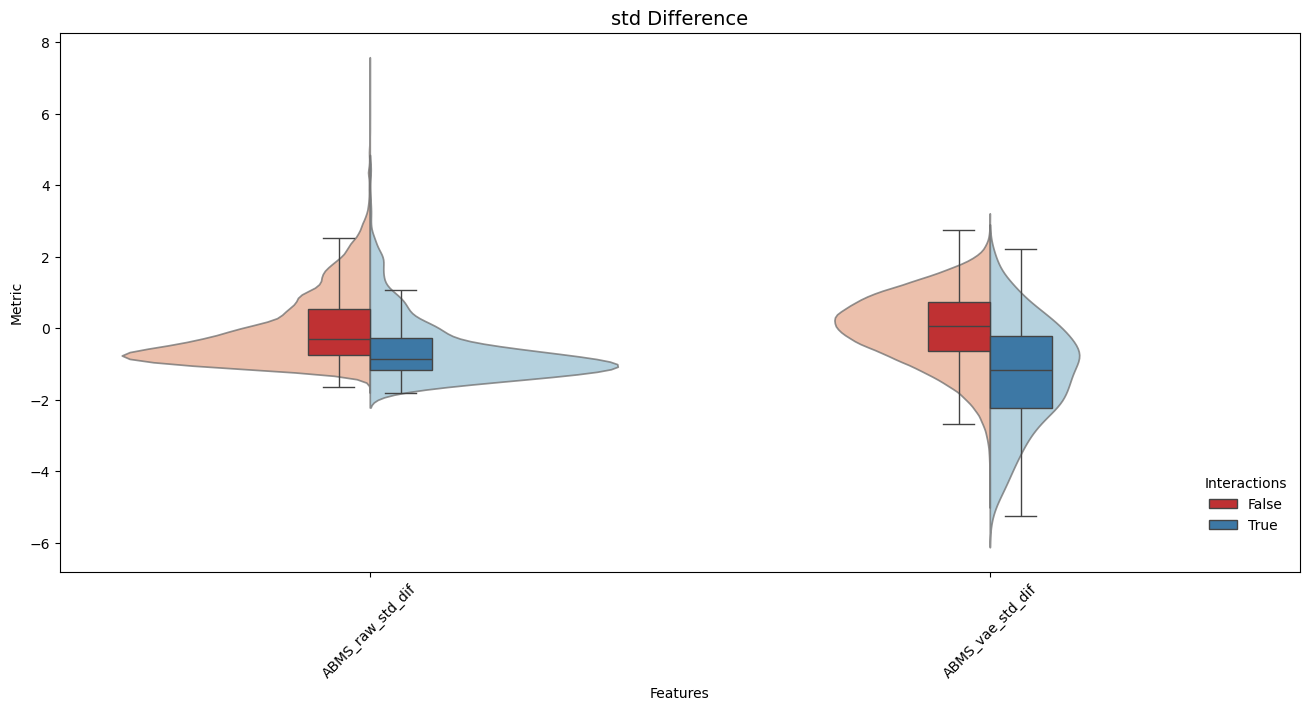

In [89]:
# melt the dataframe by all the datatypes
df = abms_features
sample_test = True
col_pattern = "std"#"abms_umap"
col_selection =  ["ABMS_vae_cos", "ABMS_umap_cos"]
# excluse = "cosine"
scale_val = True 
title = "std Difference"


# sample some for faster calculations
if sample_test:
    np.random.seed(1123)
    df = df.iloc[np.random.randint(0,df.shape[0],400000),:]

# sample the selected columns based on the column pattern
if col_pattern is None:
    cols = df.loc[:,col_selection].columns
else:
    cols = df.columns[df.columns.str.contains(col_pattern)]

# scale features so they can be visualized
# scaler = MinMaxScaler()
print(f"Scaling columns: {cols}")

if scale_val is True:
    npdf = StandardScaler().fit_transform(df[cols])
    df_scaled = pd.DataFrame(npdf, columns = df[cols].columns, index=df.index)
    df = pd.concat([df.loc[:,["Var1","Var2","db"]], df_scaled], axis=1)
  
res_melt = df.melt(id_vars=("Var1", "Var2", "db"), value_vars=tuple(cols), var_name = "Features",
                   value_name="metric")


if df["db"].dtype != object:
    res_melt["db_label"] = res_melt["db"].map({0: "False", 1: "True"})
else:
    res_melt["db_label"] = res_melt["db"].map({"F": "False", "T": "True"})
    

palette_violin = {"False": "#F4A582", "True": "#92C5DE"}  # example colors
palette_box = {"False": "#D7191C", "True": "#2C7BB6"}     # different palette

# Increase figure size and set a background style
plt.figure(figsize=(16, 7))
sns.reset_defaults()


# 3) Create the violin plot
ax = sns.violinplot(
    data=res_melt,
    x="Features",
    y="metric",
    hue="db_label",      # use the mapped column
    split=True,
    alpha=0.75,
    palette=palette_violin,
    inner=None           # remove the default internal lines/box
)

# 4) Overlay a boxplot with its own palette and size
sns.boxplot(
    data=res_melt,
    x="Features",
    y="metric",
    hue="db_label",
    palette=palette_box,
    width=0.2,           # narrower boxes so they fit inside the violin
    ax=ax,
    showfliers=False
)

handles, labels = ax.get_legend_handles_labels()
# extracts the handles froms the ax, since i used the same labels 2 times i will get
#False True False True

# Create an ordered dict or zip to preserve only unique label-handle pairs
unique = dict(zip(labels, handles))

# Re-assign the legend using unique labels, with a custom title
ax.legend(unique.values(), unique.keys(), title="Interactions", frameon=False,
          bbox_to_anchor=(1,0.2))
plt.xticks(rotation=45)
plt.title(title, fontsize = 14)
plt.xlabel("Features")
plt.ylabel("Metric")
plt.show()

In [ ]:
# palette_box_base = {"False": "#D7191C", "True": "#2C7BB6"}

# palette_box = {k: mcolors.to_rgba(v, alpha=0.7) for k, v in palette_box_base.items()}
# palette_box


In [ ]:
# print(np.nanstd(quant_df_sub.loc["AATF",:] - quant_df_sub.loc["ABCB1",:]),
# np.nanstd(quant_df_sub.loc["AATF",:] - quant_df_sub.loc["ABCF2",:]),
# np.nanstd(quant_df_sub.loc["AATF",:] - quant_df_sub.loc["ABI1",:]))
# np.nanstd(quant_df_sub.loc["ZZZ3",:] - quant_df_sub.loc["ZYG11B",:])

In [ ]:
quant_df_sub.loc["ZZZ3",:].isna().sum()

## Dataframes with different data types 

In [ ]:


x = df.loc[df.columns.str.contains("ABMS")].sample()
y = df